## Import Libraries and load cifar10 dataset.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import KFold
#import additional libraries if needed

In [16]:
def load_cifar10_data(batch_size):
# load both training and test datasets, and transform them to tensors.
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  
  return trainloader, testloader

In [17]:
batch_size = 4
trainloader, testloader = load_cifar10_data(batch_size)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Check the dimensions of a batch:
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([4, 3, 32, 32])
Image label dimensions: torch.Size([4])


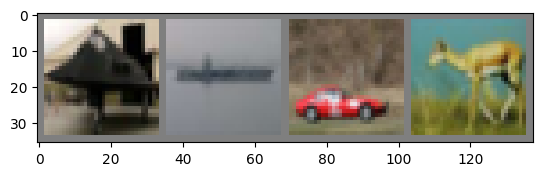

plane ship  car   deer 


In [19]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Section 1: Define your CNN model
Define your output layer, optimizer and loss criterion

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        #self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=512)
        self.fc1 = nn.Linear(in_features=256 * 4 * 4, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)

        self.relu = nn.ReLU()

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [21]:
#create model
model = CustomCNN()

## Section 2: Define optimizer and loss criterion

In [22]:
# Hyperparameters
random_seed = 20
learning_rate = 0.001
num_epochs = 10

# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# loss
loss = []
# Define the loss criterion (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

In [23]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)
criterion.to(DEVICE)

Device: cuda:0


CrossEntropyLoss()

In [28]:
# Helper function to compute the accuracy
def compute_accuracy(model, dataloader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize counters for correct predictions and total examples
    correct = 0
    total = 0

    # Iterate over the dataloader
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data

            # Move the data to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Update counters
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total

    return accuracy

In [25]:
# Helper function to compute the loss over epochs
def compute_epoch_loss(resnet, trainloader):
    loss = 0

    return loss

In [26]:
def train_model(trainloader, num_epochs, model, optimizer, loss_fn):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move the data to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

        # Print statistics

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = compute_accuracy(model, trainloader)
        #print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        print('Epoch [%d], Loss: %.4f, Accuracy: %.2f %%' % (epoch+1, running_loss/len(trainloader), epoch_accuracy))

def cross_validation(model, criterion, optimizer, trainloader, k):
    kf = KFold(n_splits=k)
    accuracies = []
    for train_idx, val_idx in kf.split(trainloader.dataset):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        trainloader_new = torch.utils.data.DataLoader(
            trainloader.dataset, 
            batch_size=batch_size, sampler=train_subsampler)
        valloader = torch.utils.data.DataLoader(
            trainloader.dataset,
            batch_size=batch_size, sampler=val_subsampler)

        # Train the model on the training subset
        train_model(trainloader_new, num_epochs, model, optimizer, criterion)

        # Evaluate the model on the validation subset
        accuracy = compute_accuracy(model, valloader)
        accuracies.append(accuracy)

    # Compute the average accuracy over all folds
    avg_accuracy = sum(accuracies) / len(accuracies)

    return avg_accuracy

In [29]:
# Perform 10-fold cross-validation
accuracy = cross_validation(model, criterion, optimizer, trainloader, k=10)
print('Accuracy:', accuracy)

# Train the model on the entire training dataset
train_model(trainloader, num_epochs, model, optimizer, criterion)

Epoch [1], Loss: 1.4329, Accuracy: 59.82 %
Epoch [2], Loss: 1.0404, Accuracy: 69.77 %
Epoch [3], Loss: 0.8002, Accuracy: 79.76 %
Epoch [4], Loss: 0.6233, Accuracy: 84.34 %
Epoch [5], Loss: 0.4854, Accuracy: 87.15 %
Epoch [6], Loss: 0.3615, Accuracy: 90.58 %
Epoch [7], Loss: 0.2582, Accuracy: 93.69 %
Epoch [8], Loss: 0.2025, Accuracy: 94.80 %
Epoch [9], Loss: 0.1532, Accuracy: 95.30 %
Epoch [10], Loss: 0.1240, Accuracy: 97.45 %
Epoch [1], Loss: 0.1793, Accuracy: 97.41 %
Epoch [2], Loss: 0.0826, Accuracy: 97.94 %
Epoch [3], Loss: 0.0779, Accuracy: 96.92 %
Epoch [4], Loss: 0.0739, Accuracy: 98.84 %
Epoch [5], Loss: 0.0630, Accuracy: 98.26 %
Epoch [6], Loss: 0.0693, Accuracy: 97.73 %
Epoch [7], Loss: 0.0599, Accuracy: 99.08 %
Epoch [8], Loss: 0.0469, Accuracy: 99.07 %
Epoch [9], Loss: 0.0366, Accuracy: 98.87 %
Epoch [10], Loss: 0.0386, Accuracy: 98.80 %
Epoch [1], Loss: 0.0659, Accuracy: 99.24 %
Epoch [2], Loss: 0.0384, Accuracy: 98.76 %
Epoch [3], Loss: 0.0328, Accuracy: 99.56 %
Epoch [4]

## Section 3: Test your model

In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [31]:
#Test for the entire dataset

def test_model(testloader, model):
    # Set the model to evaluation mode
    model.eval()

    # Initialize counters for correct predictions and total examples
    correct = 0
    total = 0

    # Iterate over the dataloader
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            # Move the data to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Update counters
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total

    #print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')
    print('Accuracy of the network on the test images:  %.2f %%' % (accuracy))

In [32]:
# # Train the model on the entire training dataset
# train_model(trainloader, num_epochs, model, optimizer, criterion)

# Test the model on the entire test dataset
test_model(testloader, model)

Accuracy of the network on the test images:  79.13 %
